In [1]:
import urllib.request
from ElementTable import element_table
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import os
import sys

sys.path.append('/Users/brianlenardo/Research/nEXO/ActivatedXenonCalibrations/ActivationCalculation/')

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams.update({'font.size': 18})

import time


In [2]:
isotopes_list = ['Xe124','Xe126','Xe128','Xe129','Xe130','Xe131','Xe132','Xe134','Xe136']

abundance_dict = {'Xe124':0.00095,
                  'Xe126':0.00089,
                  'Xe128':0.01910,
                  'Xe129':0.26401,
                  'Xe130':0.04071,
                  'Xe131':0.21232,
                  'Xe132':0.26909,
                  'Xe134':0.10436,
                  'Xe136':0.08857}







In [4]:
# Load all cross section data into a dict of dataframes
datadir = '/Users/brianlenardo/Research/nEXO/ActivatedXenonCalibrations/'+\
            'ActivationCalculation/CrossSections_copy/TENDL/'

counter = 0
maxnum = 5

xsec_dict = {}

for isotope in isotopes_list:
    
    print('Loading {}...'.format(isotope))
    
    fulldir = datadir + isotope + '/'
    
    datafiles = os.listdir(fulldir)
    
    data_list = []
    
    
    for thisfile in datafiles:
        # print(thisfile)
#         if counter > maxnum:
#             break
        if not thisfile.endswith('.txt'): 
            continue
            
        product_num = thisfile.split('_')[2]
        
        Z = int(product_num[0:3])
        A = int(product_num[3:])
#         try:
        #data = np.genfromtxt(fulldir+thisfile,skip_header=5)
        data = pd.read_csv(fulldir+thisfile,header=4,sep='\s+')
#         except UnicodeDecodeError:
#             print('Problem with {}'.format(thisfile))
        
        data_list.append({'A':A,'Z':Z,'Data':data})
        
        # print('A: {}, Z: {}'.format(A,Z))
            
        counter += 1
        
    
    
    xsec_dict[isotope] = pd.DataFrame(data_list)
    
    



Loading Xe124...
Loading Xe126...
Loading Xe128...
Loading Xe129...
Loading Xe130...
Loading Xe131...
Loading Xe132...
Loading Xe134...
Loading Xe136...


In [5]:
xsec_dict['Xe136'].head()

,A,Z,Data
0,127,52,# E xs 0 1.000000e...
1,126,52,# E xs 0 1.000000e-...
2,114,51,# E xs 0 1.000000e...
3,115,51,# E xs 0 1.000000e-...
4,112,47,# E xs 0 1.000000e...


In [6]:
df = xsec_dict['Xe136']

row = df.iloc[0]

row['Data'].iloc[:,0]


0      1.000000e-11
1      2.530000e-08
2      1.000000e-06
3      1.000000e-05
4      1.000000e-04
           ...     
116    1.400000e+02
117    1.500000e+02
118    1.600000e+02
119    1.800000e+02
120    2.000000e+02
Name: #, Length: 121, dtype: float64

In [7]:
import sys
import importlib


import Activation
importlib.reload(Activation)



<module 'Activation' from '/Users/brianlenardo/Research/nEXO/ActivatedXenonCalibrations/ActivationCalculation/Activation.py'>

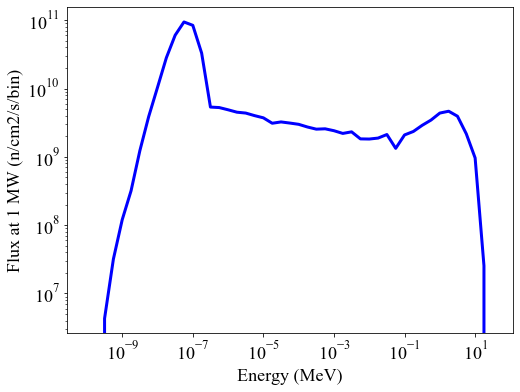

In [8]:
mnrcspec = Activation.LoadMNRCSpectrum(infile='../../MNRCNeutronActivation/mnrc_spectrum.txt')

plt.plot(mnrcspec['Energy'],mnrcspec['Fluence'],'-b',linewidth=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Flux at 1 MW (n/cm2/s/bin)')
plt.savefig('mnrc_neutron_flux_spectrum.png',dpi=300)
mnrcspec['Fluence'] = mnrcspec['Fluence']*0.25 # Here we correct to 250 kW

In [9]:
integrals_dict = {}

for isotope in isotopes_list:
    print('Integrating {}'.format(isotope))
    
    integral_df_dict_list = []
    
    for index,row in xsec_dict[isotope].iterrows():
        
        integral_df_dict = {}
        integral_df_dict['A'] = row['A']
        integral_df_dict['Z'] = row['Z']
        
        creation_int, bin_by_bin = \
            Activation.InterpolateAndIntegrateAvg( row['Data'], mnrcspec, units='mb' )
        
        integral_df_dict['Creation Rate'] = creation_int
        integral_df_dict['Bin-by-bin'] = bin_by_bin
        
        integral_df_dict_list.append(integral_df_dict)
        
    integrals_dict[isotope] = pd.DataFrame(integral_df_dict_list)




Integrating Xe124
Integrating Xe126
Integrating Xe128
Integrating Xe129
Integrating Xe130
Integrating Xe131
Integrating Xe132
Integrating Xe134
Integrating Xe136


In [91]:
integrals_dict['Xe126'].head()

,A,Z,Creation Rate,Bin-by-bin
0,107,50,0.0,"[0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, ..."
1,106,50,0.0,"[0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, ..."
2,94,44,0.0,"[0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, ..."
3,95,44,0.0,"[0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, ..."
4,101,46,0.0,"[0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, ..."


In [101]:
df = integrals_dict['Xe126']
df.loc[(df['A']==127)&(df['Z']==54)]

,A,Z,Creation Rate,Bin-by-bin
11,127,54,4.309409e-12,"[0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, ..."


In [102]:
df.loc[(df['Z']==54)&(df['A']==127)]

,A,Z,Creation Rate,Bin-by-bin
11,127,54,4.309409e-12,"[0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, ..."


In [98]:
(df['Z']==54).values

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [179]:
dfdecays = pd.read_csv('decay_table.csv')
dfnuclei = pd.read_csv('nuclei_table.csv')


dfdecays.head()
print(len(dfdecays))

dfdecays = dfdecays.loc[(dfdecays['A']>70.)&(dfdecays['A']<140.)]
dfdecays.head()
print(len(dfdecays))

2399
849


In [180]:
daughter_Z = []

for index,row in dfdecays.iterrows():
    daughter_Z.append( dfnuclei['Z'].loc[row['Daughter Element'] == dfnuclei['Element']].iloc[0] )
    
dfdecays['Daughter Z'] = daughter_Z

dfdecays.head()
    

,Unnamed: 0,A,Element,Z,Par. Elevel,Dec Mode,T1/2,Daughter A,Daughter Element,Q value,Daughter Z
245,245,72,Ni,28,0.0,B-,1.57,72,Cu,5.5569,29
265,265,72,Cu,29,0.0,B-,6.63,72,Zn,8.3625,30
266,266,73,Cu,29,0.0,B-,4.20,73,Zn,6.6060,30
267,267,74,Cu,29,0.0,B-,1.63,74,Zn,9.7510,30
278,278,71,Zn,30,0.0,B-,147.00,71,Ga,2.8101,31


In [181]:
dfnuclei.head()

,Unnamed: 0,A,Element,Z,Mass Exc,T1/2,Stable
0,0,1,H,1,7.288971,infinity,True
1,1,2,H,1,13.135722,infinity,True
2,2,3,H,1,14.949810,3.888E8,False
3,3,4,H,1,24.620000,NaN,False
4,4,5,H,1,32.890000,7.995E-23,False


In [182]:
first_timescale = 30. # minutes

time_baseline = np.linspace(0.,first_timescale*60, first_timescale*60) 

print(time_baseline)
print((int(first_timescale)*60*10,len(dfnuclei['A'])))
                    # update once per 1/10 of a second

test = np.zeros((len(dfnuclei['A']),int(first_timescale)*60*10))
print(len(test))


dfnuclei['N_atoms first 30 min'] = list(test)

dfnuclei.head()





[0.00000000e+00 1.00055586e+00 2.00111173e+00 ... 1.79799889e+03
 1.79899944e+03 1.80000000e+03]
(18000, 3987)
3987


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,A,Element,Z,Mass Exc,T1/2,Stable,N_atoms first 30 min
0,0,1,H,1,7.288971,infinity,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2,H,1,13.135722,infinity,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,3,H,1,14.949810,3.888E8,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,4,H,1,24.620000,NaN,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,5,H,1,32.890000,7.995E-23,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [184]:
dt = time_baseline[1] - time_baseline[0]

XeMass = 75. # g
XeAtomicMass = 131. # g/mol
N_A = 6.02e23
NumAtoms = XeMass / XeAtomicMass * N_A

start_time = time.time()


for i in range(len(time_baseline)-1):
#for i in range(1):
    if i % 1 == 0:
        print('Running {} of {} at {:4.4} s'.format( i,\
                                                    len(time_baseline)-1,\
                                                      time.time()-start_time))
    isotope_counter = 0.
    for index,row in dfnuclei.iterrows():
        
        if row['A'] < 70.:
            continue
        if row['A'] > 140.:
            continue
        isotope_counter += 1
        

            
        #print(float(row['T1/2']))
        if row['T1/2'] != 'infinity' and row['T1/2'] == row['T1/2']:
            decay_term = row['N_atoms first 30 min'][i] / float(row['T1/2'])
        else:
            decay_term = 0.
        
        creation_term = 0.

        for isotope, df in integrals_dict.items():
            

            creation_rate = df['Creation Rate'].values[ (df['Z'].values==int(row['Z'])) & \
                                                (df['A'].values==int(row['A'])) \
                                               ]
            #if not creation_rate.empty:
            if len(creation_rate)>0:
                if len(creation_rate) > 1:
                    print('ERROR: multiple entries in creation_rate')
                    break
                creation_term += NumAtoms * abundance_dict[isotope] * creation_rate #.values[0]
            
        
        feeding_nucleus = dfdecays.values[(dfdecays['Daughter Z'].values==int(row['Z'])) & \
                                    (dfdecays['Daughter A'].values==row['A']) & \
                                      (dfdecays['Dec Mode'].values!='IT') &\
                                      (dfdecays['Par. Elevel'].values==0.)] 
        
        
        if len(feeding_nucleus)==0:
            feeding_term = 0.
        else:
            feeding_term = dfnuclei['N_atoms first 30 min'].values[ (dfnuclei['A']==feeding_nucleus[0][1])&\
                                      (dfnuclei['Z']==feeding_nucleus[0][3]) ][0][i] / \
                       feeding_nucleus[0][-2]
            
        dfnuclei['N_atoms first 30 min'].loc[index][i+1] = dfnuclei['N_atoms first 30 min'].loc[index][i+1] + \
                    dt * (-decay_term + creation_term + feeding_term)
            
            
        #row['N_atoms first 30 min'][i+1] = 
    print(isotope_counter)
        
print('Done!')
    

Running 0 of 1799 at 0.0003359 s
1425.0
Running 1 of 1799 at 2.789 s
1425.0
Running 2 of 1799 at 5.245 s
1425.0
Running 3 of 1799 at 7.753 s
1425.0
Running 4 of 1799 at 10.55 s


KeyboardInterrupt: 

In [ ]:
# I have a decent plan, and need to edit the coe below to make it generic enough to compute arbitrary time evolution.

# Most importantly, I need to ensure that I don't try to time-evolve isotopes 
# whose halflives are much shorter than the size of the time step.

# ALSO, IMPORTANT NOTE: USE LIFETIME INSTEAD OF HALFLIFE IN THE CALCULATIONS BELOW


def ComputeActivationAndDecay(input_array, timestep, start_time, end_time, min_halflife):
    
    num_steps = (end_time-start_time)/timestep
    time_baseline = np.linspace(start_time,end_time,num_steps)
    
    XeMass = 75. # g
    XeAtomicMass = 131. # g/mol
    N_A = 6.02e23
    NumAtoms = XeMass / XeAtomicMass * N_A

    loop_begin = time.time()
    
    for i in range(len(time_baseline)-1):

        if i % 1 == 0:
            print('Running {} of {} at {:4.4} s'.format( i,\
                                                        len(time_baseline)-1,\
                                                          time.time()-start_time))
        isotope_counter = 0.
        for index,row in dfnuclei.iterrows():

            if row['A'] < 70.:
                continue
            if row['A'] > 140.:
                continue
            isotope_counter += 1


            #print(float(row['T1/2']))
            if row['T1/2'] != 'infinity' and row['T1/2'] == row['T1/2']:
                decay_term = row['N_atoms first 30 min'][i] / float(row['T1/2'])
            else:
                decay_term = 0.

            creation_term = 0.

            for isotope, df in integrals_dict.items():


                creation_rate = df['Creation Rate'].values[ (df['Z'].values==int(row['Z'])) & \
                                                    (df['A'].values==int(row['A'])) \
                                                   ]
                #if not creation_rate.empty:
                if len(creation_rate)>0:
                    if len(creation_rate) > 1:
                        print('ERROR: multiple entries in creation_rate')
                        break
                    creation_term += NumAtoms * abundance_dict[isotope] * creation_rate #.values[0]


            feeding_nucleus = dfdecays.values[(dfdecays['Daughter Z'].values==int(row['Z'])) & \
                                        (dfdecays['Daughter A'].values==row['A']) & \
                                          (dfdecays['Dec Mode'].values!='IT') &\
                                          (dfdecays['Par. Elevel'].values==0.)] 


            if len(feeding_nucleus)==0:
                feeding_term = 0.
            else:
                feeding_term = dfnuclei['N_atoms first 30 min'].values[ (dfnuclei['A']==feeding_nucleus[0][1])&\
                                          (dfnuclei['Z']==feeding_nucleus[0][3]) ][0][i] / \
                           feeding_nucleus[0][-2]

            dfnuclei['N_atoms first 30 min'].loc[index][i+1] = dfnuclei['N_atoms first 30 min'].loc[index][i+1] + \
                        dt * (-decay_term + creation_term + feeding_term)


            #row['N_atoms first 30 min'][i+1] = 
        print(isotope_counter)

    print('Done!')


In [149]:
dfdecays.head()

,Unnamed: 0,A,Element,Z,Par. Elevel,Dec Mode,T1/2,Daughter A,Daughter Element,Q value,Daughter Z
0,0,3,H,1,0.0,B-,3.888000e+08,3,He,0.018592,2
1,1,6,He,2,0.0,B-,8.070000e-01,6,Li,3.505221,3
2,2,8,He,2,0.0,B-,1.190000e-01,8,Li,10.663880,3
3,3,7,Be,4,0.0,EC,4.598208e+06,7,Li,0.861895,3
4,4,10,Be,4,0.0,B-,4.765000e+13,10,B,0.556881,5


In [51]:
df['Z'].values

array([107, 106,  94,  95, 101, 118, 119, 100, 108, 109, 126, 127, 103,
       102,  99,  98,  96,  97, 105, 104, 112, 113, 104, 105, 106, 107,
       109, 110, 111, 108,  91,  90, 116, 117, 123, 122, 110, 111,  93,
        92, 121, 120, 112, 113, 114, 115, 120, 113, 112, 115, 114, 105,
       104, 101, 100, 117, 116, 107, 106, 118, 119, 111, 110,  99,  98,
       103, 102,  96,  97, 124, 125, 117, 116, 108, 111, 110, 109, 118,
       119,  94,  95, 113, 112, 115, 114,  98,  99, 112, 113, 102, 103,
       121, 120, 106, 107, 116, 110, 111, 123, 122, 100, 119, 118, 101,
       104, 105, 106, 107, 109, 108, 100, 101,  93, 122,  92,  91, 121,
       120, 102, 103, 104, 105, 110,  99,  98, 103, 102, 105, 104,  96,
        97, 115, 114,  94,  95, 107, 117, 116, 108, 109, 101, 100, 110,
       111, 119, 118, 106, 107, 124, 116, 117, 102, 103,  98,  99, 104,
       105, 114, 115, 112, 113, 100, 101,  92,  93, 108, 109,  96,  97,
       115, 114, 113, 112, 120, 121,  90,  91, 111, 110, 122, 12

In [52]:
df = integrals_dict['Xe126']

mask = (df['Z'].values == 127)#&(df['Z']==54)
np.sum(mask)

df['Creation Rate'].loc[mask]




11    4.309409e-12
Name: Creation Rate, dtype: float64

In [3]:
test_cs = np.genfromtxt('../CrossSections_copy/TENDL/Xe131/TENDL_Xe131_042098_xsec.txt')

In [3]:
# print(test_cs)

In [4]:
target_isotope = 'Xe131'
cs_dir = '../CrossSections_copy/TENDL/{}/'.format(target_isotope)



all_files = os.listdir(cs_dir)
target_isotope_files = [filename for filename in all_files if target_isotope in filename and filename.endswith('.txt')]

#print(xe131_files)

# THIS NEXT PART IS THE PART THAT GRABS DATA FROM NNDC -- IT WORKED AT ONE POINT, BUT I THINK IT'S CURRENTLY BROKEN

In [5]:
counter = 0

reactions_list = []



for thisfile in target_isotope_files:
    
    if counter % 10 == 0:
        print('Getting file {} of {}...'.format(counter,len(target_isotope_files)))
    
    thisdict = {}
    thisdict['Target Isotope'] = target_isotope
    
    #if counter == 3: break
    #print(thisfile)
    thisdict['Cross Section'] = np.genfromtxt(cs_dir+thisfile)
    
    with open(cs_dir+thisfile) as f:
        first_line = f.readline()
        
    daughter_isotope = first_line.split()[-3]
    #print(first_line[:-1])
    print(daughter_isotope)
    thisdict['Daughter Isotope'] = daughter_isotope
    
    html_file = BeautifulSoup()
    
    html_file = urllib.request.urlopen(urlbase+daughter_isotope)
    counter += 1
    try:
        df_list = pd.read_html(html_file)
    except ValueError:
        print('No tables found (probably stable)')
        continue
    
    #print(len(df_list))
    
    new_df_list = []
    
    table_counter = 0
    for df in df_list:
        new_header = df.iloc[0]
        df = df[1:]
        df.columns = new_header
        #df.columns = df.iloc[0]
        new_df_list.append(df)
        
        if 'Parent T1/2' and 'GS-GS Q-value (keV)' in df.columns and \
            df['GS-GS Q-value (keV)'].iloc[0] == df['GS-GS Q-value (keV)'].iloc[0] and \
            'β' in df['Decay Mode'].iloc[0]:
                #print(df['Decay Mode'].iloc[0])
            
                try: 
                    float(df['Parent E(level)'].iloc[0].split('+')[0])
                except ValueError:
                    print('Problem with converting {} to a float'.format(df['Parent E(level)'].iloc[0]))
                    continue
                if float(df['Parent E(level)'].iloc[0].split('+')[0]) > 0.:
                    continue
                    
                thisdict['Daughter Q value'] = df['GS-GS Q-value (keV)'].iloc[0].split()[0]
                try:
                    halflife_val = float(df['Parent T1/2'].iloc[0].split()[0])
                except ValueError:
                    if '×' in df['Parent T1/2'].iloc[0].split()[0]:
                        temp_val = df['Parent T1/2'].iloc[0].split()[0].replace('×','E')
                        temp_val = temp_val.replace('10+','')
                        halflife_val = float(temp_val)
                    else:
                        raise ValueError
                        
                halflife_units = df['Parent T1/2'].iloc[0].split()[1]
                #print('{} {}'.format(halflife_val,halflife_units))
                if halflife_units == 'y':
                    halflife_val = halflife_val*365.
                elif halflife_units == 'd':
                    halflife_val = halflife_val/1.
                elif halflife_units == 'h':
                    halflife_val = halflife_val/24.
                elif halflife_units == 'm':
                    halflife_val = halflife_val/(60.*24.)
                elif halflife_units == 's':
                    halflife_val = halflife_val/(60. * 60. * 24.)
                elif halflife_units == 'ms':
                    halflife_val = halflife_val/(60. * 60. * 24. * 1000.)
                else:
                    print('Unknown units: {}'.format(halflife_units))
                
                thisdict['Daughter T1/2'] = halflife_val
                table_counter +=1
                if table_counter > 1:
                    print('Found an extra table in {}'.format(daughter_isotope))
                    print(df)
    if table_counter > 0:
        reactions_list.append(thisdict)
    
    
    
fulldf = pd.DataFrame(reactions_list)

Getting file 0 of 301...
111Tc
110Tc
103Ru
102Ru
No tables found (probably stable)
99Ru
No tables found (probably stable)
98Ru
No tables found (probably stable)
115Cd
114Cd
No tables found (probably stable)
96Pd
97Pd
Getting file 10 of 301...
117In
116In
101Rh
100Rh
108Sb
No tables found (probably stable)
109Sb
106Pd
No tables found (probably stable)
107Pd
93Ru
123In
Getting file 20 of 301...
92Ru
122In
Problem with converting 2.9E+214 to a float
109Ru
108Ru
No tables found (probably stable)
121Cd
120Cd
130Te
No tables found (probably stable)
104Ag
105Ag
102Cd
Getting file 30 of 301...
103Cd
No tables found (probably stable)
121Sb
No tables found (probably stable)
120Sb
98Cd
99Cd
No tables found (probably stable)
112Te
No tables found (probably stable)
113Te
114Ru
No tables found (probably stable)
115Ru
106Tc
Getting file 40 of 301...
107Tc
No tables found (probably stable)
116Rh
117Rh
No tables found (probably stable)
123Sn
122Sn
No tables found (probably stable)
119Ag
101In
No tables

In [6]:
fulldf.head(n=30)

,Target Isotope,Cross Section,Daughter Isotope,Daughter Q value,Daughter T1/2
0,Xe131,"[[1e-11, 0.0], [2.53e-08, 0.0], [1e-06, 0.0], ...",111Tc,7450,3.356481e-06
1,Xe131,"[[1e-11, 0.0], [2.53e-08, 0.0], [1e-06, 0.0], ...",110Tc,9039,1.041667e-05
2,Xe131,"[[1e-11, 0.0], [2.53e-08, 0.0], [1e-06, 0.0], ...",103Ru,763.4,3.924700e+01
3,Xe131,"[[1e-11, 0.0], [2.53e-08, 0.0], [1e-06, 0.0], ...",115Cd,1451.9,2.227500e+00
4,Xe131,"[[1e-11, 0.0], [2.53e-08, 0.0], [1e-06, 0.0], ...",117In,1455,3.000000e-02
5,Xe131,"[[1e-11, 0.0], [2.53e-08, 0.0], [1e-06, 0.0], ...",116In,3278,1.631944e-04
6,Xe131,"[[1e-11, 0.0], [2.53e-08, 0.0], [1e-06, 0.0], ...",107Pd,34.1,2.372500e+09
7,Xe131,"[[1e-11, 0.0], [2.53e-08, 0.0], [1e-06, 0.0], ...",123In,4394,7.141204e-05
8,Xe131,"[[1e-11, 0.0], [2.53e-08, 0.0], [1e-06, 0.0], ...",122In,6370,1.736111e-05
9,Xe131,"[[1e-11, 0.0], [2.53e-08, 0.0], [1e-06, 0.0], ...",109Ru,4264,3.981481e-04


In [56]:
print(new_df_list[6])
print('\n\n')
print(new_df_list[0])

0 Parent Nucleus Parent E(level) Parent Jπ Parent T1/2 Decay Mode  \
1        10344Ru             0.0      3/2+  39.247 d 3  β-: 100 %   

0 GS-GS Q-value (keV) Daughter Nucleus  DecayScheme  ENSDFfile  
1            763.4 21          10345Rh  DecayScheme  ENSDFfile  



0 Parent Nucleus Parent E(level) Parent Jπ Parent T1/2 Decay Mode  \
1        10344Ru          238.27     11/2-   1.69 ms 7         IT   

0 GS-GS Q-value (keV) Daughter Nucleus  DecayScheme  ENSDFfile  
1                 NaN          10344Ru  DecayScheme  ENSDFfile  


In [48]:
df = new_df_list[6]




In [53]:
x = df['Parent T1/2'].iloc[0]

In [54]:
x

'39.247 d 3'